> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.

### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 3 Project: Applying Difference-in-Differences
***

Welcome to the third project for Causal Inference for Data Science!

This project marks the end of our core curriculum. After this week, we'll take a brief tour of advanced methods by relating them to the ones you've already learned. We'll also work on a final "wrap-up" project that you can add to your data science portfolio.

But we're getting ahead of ourselves: We still need to complete Week 3 :)


## Scenario

Your previous analyses have gone viral within Tongass. Suddenly, everyone is talking about the "dynamic synergies" between in-store and online sales.

Pretty soon, you get a call from the CEO. "I'm blown away," she says.

"Uh, thanks," you say, trying to keep it cool.

"I'm *so* blown away that I've decided to launch new physical locations in the tri-state area. Customers in New Jersey, New York, and Connecticut will have way more options going forward!"

"Wow!" you reply. "That's amazing."

"Indeed, but I want to make sure we approach this launch thoughtfully before we expand to other geos. Could you analyze the impact of opening new stores in these states?"

"Of course!" you say. "I'll make sure we have a solid causal inference plan and get a rigorous read on how these openings affect Tongass's business."

"Causal inference what now?"

"Sorry," you reply. "The point is: We're going to show Amazon who's boss."

"Excellent!" she says.


## Project notes

As always, we start with the same notes:

### Data

We will work with a consistent data set througout this course (we introduce the data set more fully below). Not all parts of the data set will be applicable in any given week. The goal is demonstrating how a single set of granular data can be transformed to apply different causal inference techniques. We also hope to convey that manipulating data is in many ways the most important aspect of statistical modeling.

### Structure

We attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis. If this freedom is overwhelming, **don't panic**! You can simply fill out the code blocks marked "TODO" and ignore the optional ones. When we ask you to build models, we will provide the treatment effect you should expect so you can check your work.

In [ ]:
# loading necessary packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

## I. Load the data
***

We will work with a consistent data set throughout this course. The data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. As we'll discuss, this week's problem can be tackled at different levels of aggregation (e.g., individuals, states, treatment v. control groups). We'll need to be thoughtful about how to aggregate our data.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer
- `state`: the customer's state of residence
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

**NOTE**: If we don't mention a field above, then it won't be relevant for this week :)

In [ ]:
# TODO: read in data (already filled out for you :)
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head()

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0


## II. Modify the data set to prepare it for difference-in-differences analysis
***

In previous weeks, we got familiar with the data set. (If we hadn't, we would recommend repeating that step from Week 1!)

Now, we want to approach our data through the lens of difference-in-differences specifically.

First, that means adding in "treatment" and "time period" variables. Let's do that below.

In [ ]:
treated_states = ['NJ', 'NY', 'CT'] # stores open in these states, so treatment will be if state shows up within these states
store_opening_date = '2021-03-31' # stores open during this month, so treatment period will be any observation at/after this time

In [ ]:
# TODO: use the "treated_states" list to create a column for whether
# an observation is in treatment group; use the "store_opening_date" variable
# to create a column for whether an observation happens after treatment begins. keep in mind
# that using 1s and 0s is more convenient than "True"s and "False"s when it comes to
# fitting linear regressions
df['is_treated_state'] = df.state.apply(lambda x: 1 if x in treated_states else 0)
df['is_post_treatment'] = df.tx_date.apply(lambda x: 1 if x >= store_opening_date else 0)

## III. Aggregate the data set to the appropriate "level" and vet the parallel trends assumption; this also helps us see if our causal question is worth answering (spoiler: it will be)
***

As you know, difference-in-differences analysis hinges on a critical assumption known as "parallel trends" — that is, in the absence of the treatment, the treatment group would have seen the same trends as the control group.

Unfortunately, we can never be 100% confident in parallel trends; however, we can at least gain some comfort with it.

One way is by comparing the treatment and control groups visually to see whether they follow parallel trends prior to treatment. Try this now.

The [seaborn lineplot function](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is particularly helpful here.

**Keep in mind that we could do this analysis at multiple "levels"**: in particular, we could visualize and model the effect of treatment on individual customers, states, or treatment/control groups overall. Similarly, we could aggregate the data to the month level or simply to the "pre/post" level. For this project, we'll aggregate the data to the "state" and "month" level, but there is no right answer here. Indeed, we'd encourage you to experiment with different levels of analysis to see how that changes your modeling process, but we'll leave that to the optional section below ;)

In [ ]:
# TODO: aggregate data to state/month level and visualize treatment versus control for parallel trends like we did in lecture/written material
dfg = df.groupby(['state', 'tx_date', 'is_treated_state', 'is_post_treatment']).agg({
    'amount': 'sum' # outcome variable of interest
    # TODO (OPTIONAL): See optional section below — you could include other control variables
    # here that might lead to more precise estimates of the treatment effect, but there
    # are important nuances to keep in mind
}).reset_index()

# here's an example of how we might want to include controls —
# aggregate data to customer level and then take averages
# in each month to account for changing characteristics of customer
# population
df_controls = df.groupby(['state', 'customer_id', 'tx_date']).agg({
    'income': 'first'
}).groupby(['state', 'tx_date']).agg({
    'income': 'mean'
}).reset_index()

dfg = pd.merge(dfg, df_controls, on=['state', 'tx_date'])

dfg.head()

,state,tx_date,is_treated_state,is_post_treatment,amount,income
0,AK,2020-01-31,0,0,5825.018347,146244.683544
1,AK,2020-02-29,0,0,6369.142526,135874.160920
2,AK,2020-03-31,0,0,6181.065016,142846.682353
3,AK,2020-04-30,0,0,7282.857834,151562.121212
4,AK,2020-05-31,0,0,5666.744875,133015.493671


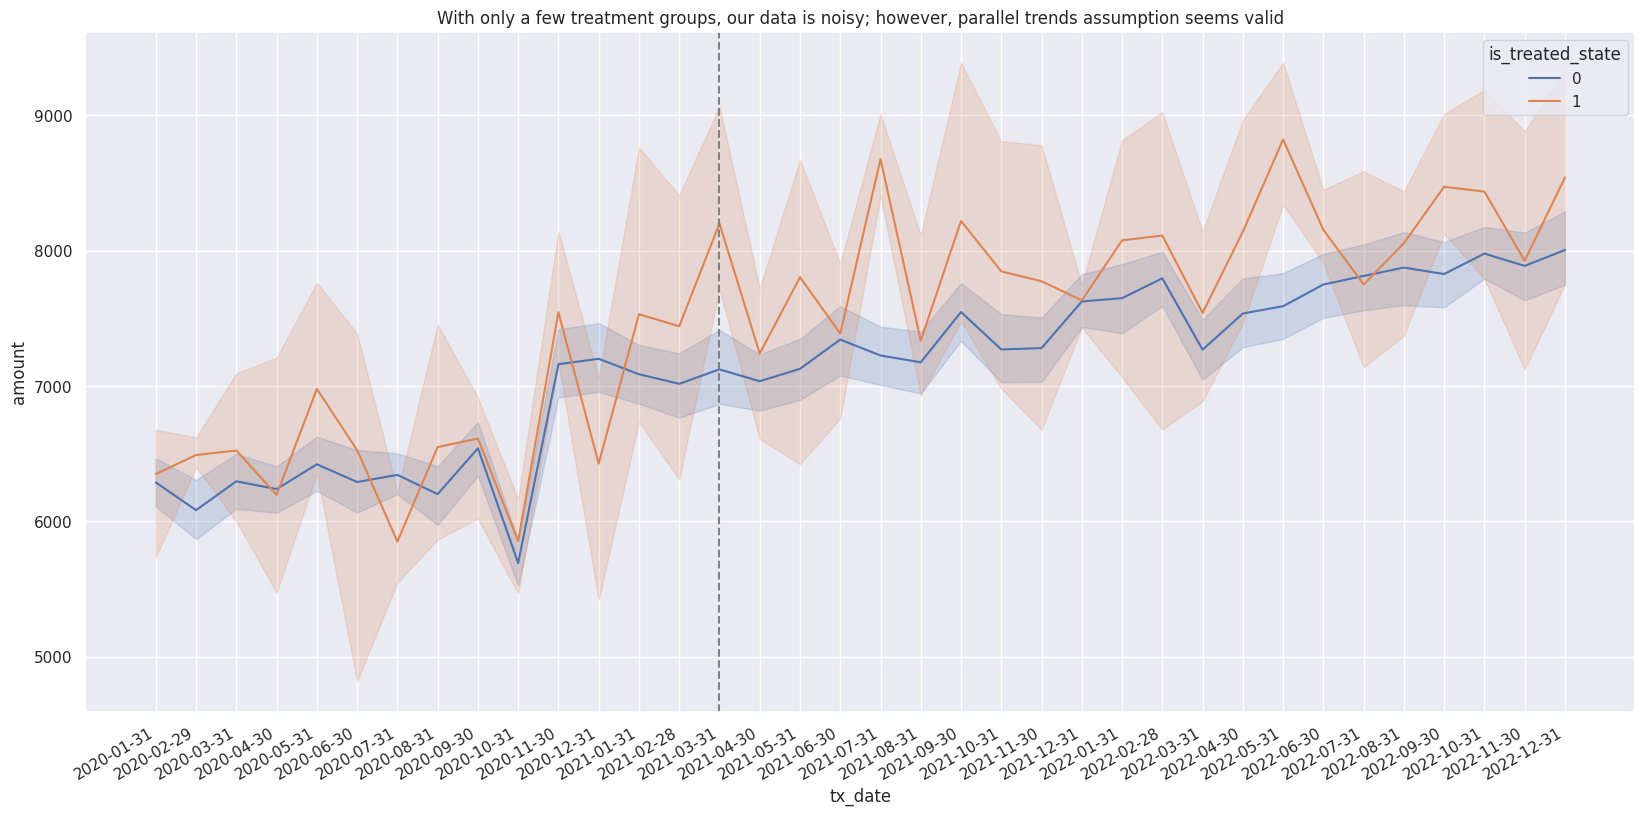

In [ ]:
# TODO: Visually inspect the parallel trends assumption
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(x='tx_date', y='amount', hue='is_treated_state', data=dfg, ax=ax)
ax.set(
    title='With only a few treatment groups, our data is noisy; however, parallel trends assumption seems valid'
)
fig.autofmt_xdate()
ax.axvline(store_opening_date, ls='--', color='grey')

## IV. Fit difference-in-differences model and interpret the results
***

Woohoo! It's finally time to start modeling. Fit a DD regression using state and month as controls (similar to how we fit a DD regression using farm and month as controls in this week's material).

In [ ]:
# TODO: fit a difference-in-differences model and interpret the results

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~329 (with a 95% CI of 48 to 610)
reg = smf.ols('amount ~ tx_date + state + is_treated_state:is_post_treatment', data=dfg).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     24.51
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          3.39e-239
Time:                        13:57:51   Log-Likelihood:                -14601.
No. Observations:                1836   AIC:                         2.938e+04
Df Residuals:                    1749   BIC:                         2.986e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           6184.8589    152.622     40.524      0.000    5885.518    6484.199
tx_date[T.2020-02-29]               -184.1377    139.568     -1.319      0.187    -457.875      89.600
tx_date[T.2020-03-31]                 18.3229    139.568      0.131      0.896    -255.415     292.061
tx_date[T.2020-04-30]                -55.2575    139.568     -0.396      0.692    -328.995     218.480
tx_date[T.2020-05-31]                163.3424    139.568      1.170      0.242    -110.395     437.080
tx_date[T.2020-06-30]                 13.5684    139.568      0.097      0.923    -260.169     287.306
tx_date[T.2020-07-31]                 23.4617    139.568      0.168      0.867    -250.276     297.199
tx_date[T.2020-08-31]                -69.3308    139.568     -0.497      0.619    -343.068     204.407
tx_date[T.2020-09-30]                253.0158    139.568      1.813      0.070     -20.722     526.753
tx_date[T.2020-10-31]               -589.2892    139.568     -4.222      0.000    -863.027    -315.552
tx_date[T.2020-11-30]                892.8388    139.568      6.397      0.000     619.101    1166.576
tx_date[T.2020-12-31]                864.2388    139.568      6.192      0.000     590.501    1137.976
tx_date[T.2021-01-31]                822.0462    139.568      5.890      0.000     548.309    1095.784
tx_date[T.2021-02-28]                750.0599    139.568      5.374      0.000     476.322    1023.798
tx_date[T.2021-03-31]                875.7965    139.823      6.264      0.000     601.559    1150.034
tx_date[T.2021-04-30]                736.9869    139.823      5.271      0.000     462.750    1011.224
tx_date[T.2021-05-31]                856.3445    139.823      6.125      0.000     582.107    1130.582
tx_date[T.2021-06-30]               1035.1383    139.823      7.403      0.000     760.901    1309.375
tx_date[T.2021-07-31]               1000.3639    139.823      7.155      0.000     726.127    1274.601
tx_date[T.2021-08-31]                874.2880    139.823      6.253      0.000     600.051    1148.525
tx_date[T.2021-09-30]               1275.4258    139.823      9.122      0.000    1001.189    1549.663
tx_date[T.2021-10-31]                993.6324    139.823      7.106      0.000     719.395    1267.870
tx_date[T.2021-11-30]                998.7740    139.823      7.143      0.000     724.537    1273.011
tx_date[T.2021-12-31]               1314.4132    139.823      9.401      0.000    1040.176    1588.650
tx_date[T.2022-01-31]               1363.8907    139.823      9.754      0.000    1089.654    1638.128
tx_date[T.2022-02-28]               1503.5549    139.823     10.753      0.000    1229.318    1777.792
tx_date[T.2022-03-31]                973.6569    139.823      6.964      0.000     699.420    12

The new store openings caused monthly sales in treated states to increase by \$330 per month (with a 95% CI of \$48-\$610).

## V. Cluster your standard errors
***

Given how we chose to aggregate our data, we should cluster our standard errors to see if that changes the precision of our estimated treatment effect.

Indeed, regardless of whether we fit our model at the customer- or state-level, it's common to cluster standard errors at the level of treatment (in this case, "state" is the level of treatment). It's also reasonable to try to-way clustering (e.g., at the state- _and_ month-level), although we don't need to worry about that for now.

The key thing to remember about clustering is that it helps us account for subtle correlations between observations. Even if we account for state-level effects by including `state` in our model, our within-state error terms could still be correlated (e.g., if the economy in one or two states randomly booms, it might encourage shoppers in that state to spend more).

Unfortunately, there is no "one-size fits-all" guidance about how to cluster your standard errors. (If you want a ton of detail, [this](https://cameron.econ.ucdavis.edu/research/Cameron_Miller_JHR_2015_February.pdf) is an excellent resource.) We personally like to try different justifiable clustering strategies and pick the most conservative (i.e., least precise), although that is largely a function of us working in data-rich tech industry. If you're dealign with small data sets, you may need to dive deeper here to ensure your inference is valid!

In [ ]:
# TODO: cluster your standard errors at the state-level
# CHECK: Your clustered standard errors should actually be lower than the
# unclustered versions — but remember: that can happen when intra-cluster correlations are negative!
# (In reality... I didn't actually add serial correlation to our data set because generating the synethic data set was already quite complex ;)
reg.get_robustcov_results(cov_type='cluster', groups=dfg.state).summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 36
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     100.0
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           5.28e-36
Time:                        01:47:47   Log-Likelihood:                -14601.
No. Observations:                1836   AIC:                         2.938e+04
Df Residuals:                    1749   BIC:                         2.986e+04
Df Model:                          86                                         
Covariance Type:              cluster                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           6184.8589     83.739     73.859      0.000    6016.665    6353.053
tx_date[T.2020-02-29]               -184.1377    125.009     -1.473      0.147    -435.227      66.951
tx_date[T.2020-03-31]                 18.3229    116.006      0.158      0.875    -214.682     251.327
tx_date[T.2020-04-30]                -55.2575    127.945     -0.432      0.668    -312.242     201.727
tx_date[T.2020-05-31]                163.3424    123.308      1.325      0.191     -84.329     411.014
tx_date[T.2020-06-30]                 13.5684    128.630      0.105      0.916    -244.793     271.930
tx_date[T.2020-07-31]                 23.4617    112.182      0.209      0.835    -201.863     248.786
tx_date[T.2020-08-31]                -69.3308    132.423     -0.524      0.603    -335.311     196.649
tx_date[T.2020-09-30]                253.0158    108.849      2.324      0.024      34.387     471.645
tx_date[T.2020-10-31]               -589.2892     98.446     -5.986      0.000    -787.024    -391.554
tx_date[T.2020-11-30]                892.8388    129.999      6.868      0.000     631.728    1153.950
tx_date[T.2020-12-31]                864.2388    131.963      6.549      0.000     599.183    1129.295
tx_date[T.2021-01-31]                822.0462    134.098      6.130      0.000     552.703    1091.390
tx_date[T.2021-02-28]                750.0599    146.853      5.108      0.000     455.098    1045.022
tx_date[T.2021-03-31]                875.7965    143.856      6.088      0.000     586.854    1164.739
tx_date[T.2021-04-30]                736.9869    119.117      6.187      0.000     497.733     976.241
tx_date[T.2021-05-31]                856.3445    119.377      7.173      0.000     616.569    1096.120
tx_date[T.2021-06-30]               1035.1383    147.095      7.037      0.000     739.688    1330.588
tx_date[T.2021-07-31]               1000.3639    130.425      7.670      0.000     738.398    1262.330
tx_date[T.2021-08-31]                874.2880    111.779      7.822      0.000     649.774    1098.802
tx_date[T.2021-09-30]               1275.4258    129.098      9.880      0.000    1016.126    1534.726
tx_date[T.2021-10-31]                993.6324    125.658      7.907      0.000     741.241    1246.024
tx_date[T.2021-11-30]                998.7740    133.918      7.458      0.000     729.792    1267.756
tx_date[T.2021-12-31]               1314.4132    120.329     10.923      0.000    1072.724    1556.102
tx_date[T.2022-01-31]               1363.8907    148.468      9.186      0.000    1065.684    1662.098
tx_date[T.2022-02-28]               1503.5549    145.572     10.329      0.000    1211.166    1795.944
tx_date[T.2022-03-31]                973.6569    130.513      7.460      0.000     711.515    12

Given the unintuitive results, we'd likely want to triple-check our model was specified correctly. Assuming it was, we would opt for the more conservative model with unclustered standard errors. (Although note: Some of the leading minds in econometrics [would disagree](https://blogs.worldbank.org/impactevaluations/when-should-you-cluster-standard-errors-new-wisdom-econometrics-oracle)! In particular, their argument is that clustering is appropriate when the treatment is assigned at the level of the group rather than the individual (which is obviously true in this case).

Thus, even if clustering doesn't change our results much, or changes them in an unintuitive way, it's still appropriate to favor our unclustered standard errors.

That said... In most real-world settings we're likely to work in, this hopefully won't be too make-or-break. Hence: Our recommendation to err on the conservative side.

## VI. Tease out the causal mechanism by considering different outcome variables
***

In your analysis above, you likely use `amount` as your dependent variable. But there are other possible dependent variables we could consider, e.g., in-store sales or online sales.

Try repeating your model-fitting process with these dependent variables.

These complementary models help us determine whether opening new stores **only** boosts in-store sales, or whether overall sales increase but at the expense of online sales. Although overall sales is probably most important from a business standpoint, it's still important to understand _why_ a treatment works. We don't want people to think there are "dynamic synergies" between online and physical stores when, in reality, physical stores simply encourage customers to ignore the website.

In [ ]:
# TODO: fit a version of your final model with "in-store sales" as your outcome variable (i.e., repeat above
# analysis but filtering to in_store = 1 during data aggregation)

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~1955

# TODO: aggregate data to state/month level and visualize treatment versus control for parallel trends like we did in lecture/written material
dfg_instore = df[df['in_store'] == 1].groupby(['state', 'tx_date', 'is_treated_state', 'is_post_treatment']).agg({
    'amount': 'sum' # outcome variable of interest
    # TODO (OPTIONAL): See optional section below — you could include other control variables
    # here that might lead to more precise estimates of the treatment effect, but there
    # are important nuances to keep in mind
    ,'income': 'mean' # won't include in models below, but you could!
}).reset_index()

reg_in_store = smf.ols('amount ~ tx_date + state + is_treated_state:is_post_treatment', data=dfg_instore).fit()
reg_in_store.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     165.2
Date:                Tue, 27 Jun 2023   Prob (F-statistic):               0.00
Time:                        01:52:03   Log-Likelihood:                -14323.
No. Observations:                1836   AIC:                         2.882e+04
Df Residuals:                    1749   BIC:                         2.930e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1262.1837    131.198      9.620      0.000    1004.862    1519.505
tx_date[T.2020-02-29]                -97.5279    119.977     -0.813      0.416    -332.841     137.785
tx_date[T.2020-03-31]                 -4.3733    119.977     -0.036      0.971    -239.686     230.939
tx_date[T.2020-04-30]                 89.2854    119.977      0.744      0.457    -146.027     324.598
tx_date[T.2020-05-31]                 62.8070    119.977      0.523      0.601    -172.506     298.120
tx_date[T.2020-06-30]                 69.3791    119.977      0.578      0.563    -165.934     304.692
tx_date[T.2020-07-31]                106.3293    119.977      0.886      0.376    -128.983     341.642
tx_date[T.2020-08-31]                170.9323    119.977      1.425      0.154     -64.380     406.245
tx_date[T.2020-09-30]                315.7179    119.977      2.631      0.009      80.405     551.031
tx_date[T.2020-10-31]               1685.8218    119.977     14.051      0.000    1450.509    1921.134
tx_date[T.2020-11-30]               3127.6467    119.977     26.069      0.000    2892.334    3362.959
tx_date[T.2020-12-31]               3059.9973    119.977     25.505      0.000    2824.685    3295.310
tx_date[T.2021-01-31]               3023.2782    119.977     25.199      0.000    2787.966    3258.591
tx_date[T.2021-02-28]               2769.2258    119.977     23.081      0.000    2533.913    3004.538
tx_date[T.2021-03-31]               2926.3765    120.196     24.347      0.000    2690.634    3162.118
tx_date[T.2021-04-30]               2768.6263    120.196     23.034      0.000    2532.884    3004.368
tx_date[T.2021-05-31]               2950.3076    120.196     24.546      0.000    2714.566    3186.050
tx_date[T.2021-06-30]               3119.9359    120.196     25.957      0.000    2884.194    3355.678
tx_date[T.2021-07-31]               3121.2702    120.196     25.968      0.000    2885.528    3357.012
tx_date[T.2021-08-31]               3104.5700    120.196     25.829      0.000    2868.828    3340.312
tx_date[T.2021-09-30]               3264.3173    120.196     27.158      0.000    3028.575    3500.059
tx_date[T.2021-10-31]               3231.7073    120.196     26.887      0.000    2995.965    3467.449
tx_date[T.2021-11-30]               3238.8127    120.196     26.946      0.000    3003.071    3474.555
tx_date[T.2021-12-31]               3538.4457    120.196     29.439      0.000    3302.704    3774.188
tx_date[T.2022-01-31]               3561.8281    120.196     29.634      0.000    3326.086    3797.570
tx_date[T.2022-02-28]               3654.3867    120.196     30.404      0.000    3418.645    3890.129
tx_date[T.2022-03-31]               3299.0927    120.196     27.448      0.000    3063.351    35

In [ ]:
# TODO: fit a version of your final model with "online sales" as your outcome variable (i.e., repeat above
# analysis but filtering to in_store = 0 during data aggregation)

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~1612

# TODO: aggregate data to state/month level and visualize treatment versus control for parallel trends like we did in lecture/written material
dfg_instore = df[df['in_store'] == 0].groupby(['state', 'tx_date', 'is_treated_state', 'is_post_treatment']).agg({
    'amount': 'sum' # outcome variable of interest
    # TODO (OPTIONAL): See optional section below — you could include other control variables
    # here that might lead to more precise estimates of the treatment effect, but there
    # are important nuances to keep in mind
    ,'income': 'mean' # won't include in models below, but you could!
}).reset_index()

reg_in_store = smf.ols('amount ~ tx_date + state + is_treated_state:is_post_treatment', data=dfg_instore).fit()
reg_in_store.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     147.1
Date:                Tue, 27 Jun 2023   Prob (F-statistic):               0.00
Time:                        01:52:19   Log-Likelihood:                -13556.
No. Observations:                1825   AIC:                         2.729e+04
Df Residuals:                    1738   BIC:                         2.777e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           4922.6752     90.327     54.498      0.000    4745.514    5099.836
tx_date[T.2020-02-29]                -86.6098     82.601     -1.049      0.295    -248.618      75.399
tx_date[T.2020-03-31]                 22.6962     82.601      0.275      0.784    -139.312     184.705
tx_date[T.2020-04-30]               -144.5429     82.601     -1.750      0.080    -306.551      17.466
tx_date[T.2020-05-31]                100.5354     82.601      1.217      0.224     -61.473     262.544
tx_date[T.2020-06-30]                -55.8107     82.601     -0.676      0.499    -217.819     106.198
tx_date[T.2020-07-31]                -82.8677     82.601     -1.003      0.316    -244.876      79.141
tx_date[T.2020-08-31]               -240.2631     82.601     -2.909      0.004    -402.272     -78.255
tx_date[T.2020-09-30]                -62.7021     82.601     -0.759      0.448    -224.710      99.306
tx_date[T.2020-10-31]              -2275.1110     82.601    -27.543      0.000   -2437.119   -2113.103
tx_date[T.2020-11-30]              -2234.8079     82.601    -27.055      0.000   -2396.816   -2072.800
tx_date[T.2020-12-31]              -2195.7585     82.601    -26.583      0.000   -2357.767   -2033.750
tx_date[T.2021-01-31]              -2201.2320     82.601    -26.649      0.000   -2363.240   -2039.224
tx_date[T.2021-02-28]              -2019.1659     82.601    -24.445      0.000   -2181.174   -1857.157
tx_date[T.2021-03-31]              -2051.3828     82.764    -24.786      0.000   -2213.710   -1889.056
tx_date[T.2021-04-30]              -2027.9778     83.146    -24.391      0.000   -2191.054   -1864.901
tx_date[T.2021-05-31]              -2094.7659     82.764    -25.310      0.000   -2257.093   -1932.439
tx_date[T.2021-06-30]              -2079.6300     83.144    -25.012      0.000   -2242.703   -1916.557
tx_date[T.2021-07-31]              -2119.0301     83.146    -25.486      0.000   -2282.106   -1955.954
tx_date[T.2021-08-31]              -2231.0847     82.764    -26.957      0.000   -2393.412   -2068.758
tx_date[T.2021-09-30]              -1989.6942     82.764    -24.041      0.000   -2152.021   -1827.367
tx_date[T.2021-10-31]              -2235.9729     83.144    -26.893      0.000   -2399.046   -2072.900
tx_date[T.2021-11-30]              -2240.5451     83.146    -26.947      0.000   -2403.622   -2077.469
tx_date[T.2021-12-31]              -2224.8352     82.764    -26.882      0.000   -2387.162   -2062.508
tx_date[T.2022-01-31]              -2198.7401     82.764    -26.566      0.000   -2361.067   -2036.413
tx_date[T.2022-02-28]              -2151.6346     82.764    -25.997      0.000   -2313.962   -1989.308
tx_date[T.2022-03-31]              -2322.2013     83.549    -27.795      0.000   -2486.068   -21

Perhaps unsurprisingly, the treatment seems to be causing an extreme substitution effect from online to in-store shopping.

In treated states, in-store sales rose by nearly \$2,000 per month on average! However, we know that, overall, sales rose by ~\$300. Thus, it's not surprising that online sales declined by \$1,612 in these states.

Deciding on this strategy will ultimately be a more involved decision, as it will depend on the cost of managing more stores and the long-run strategic vision of the company.

## VII. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so the Tongas CEO can follow along.

We will annoyingly repeat the same advice from previous weeks:

This step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested steps, but feel free to tweak as you see fit:
- Share the results from your final model, making sure to put the results in **business terms** (e.g., "opening stores in the tri-state area increased online sales by X and total sales by Y. Assuming stores cost less than Z to operate, or we can continue to increase revenues, we should do this in more states")
- Show key visuals to help someone grok the relationship intuitively
- Comment on our degree of confidence of results, both in quantitative terms (e.g., confidence interval) and qualitative terms (e.g., "model seems robust/sensitive to controls, which means we can be confident/should consider this a preliminary hypothesis warranting deeper experimentation")

The promotional campaign effectively brings $329 in additional sales in states that are treated.
The promotional campaign works by displacing sales from online to in-store: the promotion led to an average increase of 20% in the percentage of in-store sales(95% CI: 118%-22%).
It is out of scope of this analysis to recommend whether the cannibalization of online sales from in-store sales is the best business outcome.

In [ ]:
# TODO: change this cell to a markdown cell and write an "executive summary" that
# explains your results

# NOTE: NOT FILLED OUT IN SOLUTION KEY BUT COULD ADD IF IT WOULD BE HELPFUL

In [ ]:
# TODO: output a key visual (either from above or a new one) that you think communicates
# your results in a statistically responsible way (tip: the same visual you used for parallel
# trends might be helpful here)

In [ ]:
# TODO: change this cell to a markdown cell and write a blurb on how confident you
# are in your results and why

## VIII. OPTIONAL: Consider additional analysis steps
***
1. We didn't ask for this explicitly, but it's possible to include additional controls in our difference-in-difference models to improve the precision of our estimates. For example, we might want to include additional "state-level" variables (e.g., average age of state, average distance of customers in state, etc.) to ensure we account for such differences between states. Consider fitting additional models with these kinds of controls. A few notes about this:
  - Since we already include state-level controls, we should only include additional controls if they _vary_ over time. (If they were stable over time, or "time-invariant," then they would be perfectly correlated with the state controls and cause a perfect multicollinearity problem.)
  - In our case, the controls we could include (e.g., average income by state) _do_ vary over time since the characteristics of our customer-base changes.
  - However, it's important to note that the treatment of opening new stores could *causally affect* the kinds of customers who shop at Tongass. If so, relying on these controls could constitute a **bad controm problem.**
  - The "best" way of accomplishing the spirit of this optional task is by including state-level confounders that we know are far removed for our treatment, e.g., we could include a state's unemployment rate over time, or something more Tongass-specific like our marketing department's spend in each state over time. This is almost certainly overkill for an analysis like ours, but would better capture the goal of including such information in our model. For now, you can practice with these potentially tainted controls to see what happens to our model.
2. We would highly recommend tackling this problem in multiple ways to see how it changes your analysis. For example, you could try aggregating to an even higher level (just treatment v. control groups, just pre v. post time periods) to see and whether that changes your estimated treatment effect. Conversely, it's possible to go the other way and repeat this analysis at the individual _customer_ level. How would that analysis look? What causal question would that analysis be answering? (Note: This gets complicated, and we didn't want to get into all the nuances of panel data methods — that's a broader set of problems than difference-in-differences! That said, if you're interested, consider doing some reading about modeling individual panel data where observations are clustered into higher-level units (in this case, states) and tackling it again). You have all the foundational tools you need to take this on!
3. The [`linearmodels`](https://bashtage.github.io/linearmodels/index.html) package in Python is made for working with panel data (e.g., it doesn't include every single state and month in your regression summary ;). Consider fitting models in this package so you have another tool in your DS arsenal.
4. An important robustness check in some DD models is allowing variable time trends. As mentioned in the written material for this week, differential time trends allow for the possibility that treatment and control groups were following different (non-parallel ;) trends prior to treatment. Consider fitting another model with variable time trends as a robustness check. (TBH, this is mostly so you have practice — we can see from the parallel trends visualization that we don't need to worry about differential time trends.)

## IX. EXTREMELY OPTIONAL: Tackle another problem
***

When it comes to learning causal inference, there is no substitute for practice. We would strongly support finding data sets in the wild (e.g. [here](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0), [here](https://ourworldindata.org/), or [here](https://github.com/awesomedata/awesome-public-datasets) and using the same general framework we leveraged here toward a causal question you're interested in.